# Summary:

In this notebook, I just load the TNG data and repeatedly fit the data with an increasing number of randonly drawn satellites above a certain mass threshold. Question: How many TNG satellites are needed to demonstrate that a sinsusoid function is necessary.

In order to calculate this, I increase the number of satellites in the sample by a set amount (not too finely spaced, otherwise the code will take too long) and for that number of satellites, calculate the MCMC fit 1,000-10,000 times in order to get a distribution on the b paramater mean divided by the b parameter standard deviation. 

In [1]:
# import libraries, set font, ect.

import matplotlib.pyplot as plt 
%matplotlib inline 

import astropy as ap
from astropy import units as u
from fractions import Fraction 
import astroquery as aq
import numpy as np
from astropy.table import Table
import array as arr
import pandas as pd
import scipy.stats
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy.table import Table, join

import scipy.interpolate as interp
import scipy
import emcee
import corner
import sys

import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"], 
    "mathtext.fontset": "cm",  
    "axes.unicode_minus": False
})


## MCMC fit: 

In [2]:
def boostrap_90(data,sf_index,q_index,N):
    
    bins = 18 # same as boostrap function
    dphi = 90/bins/2
    n_bootstrap = N  # number of bootstrap resamples

    # arrays to hold bootstrapped quenched fractions
    boot_fq = np.zeros((n_bootstrap, bins))

    # loop over bootstrap resamples
    for i in range(n_bootstrap):

        sf_sample = data.loc[sf_index].sample(frac=1, replace=True)
        q_sample  = data.loc[q_index].sample(frac=1, replace=True)
        
        g_N_sf, _ = np.histogram(sf_sample['alpha'],density=False, range=[0,90], bins=bins)
        g_N_q, _  = np.histogram(q_sample['alpha'],density=False, range=[0,90], bins=bins)

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0  # handle empty bins
        
        boot_fq[i] = fq
    
    fq_mean = np.nanmean(boot_fq, axis=0)
    fq_std = np.nanstd(boot_fq, axis=0)

    return fq_mean, fq_std


In [13]:
# load TNG100 data
# just once 

angle_array = np.loadtxt('angle_array.txt')

# load 1e8 data

df_tng100 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_mstar_1e8.csv")
df_tng100_host_mh = pd.read_csv("satellite_1e8/centrals_satellites_tng100_host_mh_1e8.csv")
df_tng100_alpha = pd.read_csv("satellite_1e8/centrals_satellites_tng100_alpha_1e8.csv")
tng100_sfr_info = pd.read_csv("satellite_1e8/tng100_sfr_info_1e8.csv")

index = (df_tng100_host_mh['host_mh'] > 12) & (df_tng100_host_mh['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info['host_mh'][index]))
q_sf_array[index_sf] = 0.

# load 1e7 data

df_tng100 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_mstar_1e7.csv")
df_tng100_host_mh = pd.read_csv("satellite_1e7/centrals_satellites_tng100_host_mh_1e7.csv")
df_tng100_alpha = pd.read_csv("satellite_1e7/centrals_satellites_tng100_alpha_1e7.csv")
tng100_sfr_info = pd.read_csv("satellite_1e7/tng100_sfr_info_1e7.csv")

index = (df_tng100_host_mh['host_mh'] > 12) & (df_tng100_host_mh['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info['host_mh'][index]))
q_sf_array[index_sf] = 0.

# load 1e6 data

df_tng100 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_mstar_1e6.csv")
df_tng100_host_mh = pd.read_csv("satellite_1e6/centrals_satellites_tng100_host_mh_1e6.csv")
df_tng100_alpha = pd.read_csv("satellite_1e6/centrals_satellites_tng100_alpha_1e6.csv")
tng100_sfr_info = pd.read_csv("satellite_1e6/tng100_sfr_info_1e6.csv")

index = (df_tng100_host_mh['host_mh'] > 12) & (df_tng100_host_mh['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info['host_mh'][index]))
q_sf_array[index_sf] = 0.

In [14]:
tng100_sfr_info[index]

,mstar,host_mh,sfr,alpha
44146,10.645367,12.343892,6.254248,13.929357
44147,10.479766,12.343892,6.023962,48.382907
44148,9.916242,12.343892,0.887909,34.680160
44149,10.243932,12.343892,1.725496,42.294462
44150,9.622143,12.343892,0.101011,1.003089
...,...,...,...,...
65674,6.823749,12.018503,0.000000,23.790231
65675,6.001571,12.018503,0.000000,81.505670
65676,6.492132,12.007953,0.000000,37.749647
65677,6.348691,12.007953,0.000000,81.903372


In [41]:
subsample = tng100_sfr_info[index].sample(n=2,replace=True,random_state=rng.integers(0, 2**32))

In [81]:
def boostrap_90(data,sf_index,q_index,N):
    
    bins = 18 # same as boostrap function
    dphi = 90/bins/2
    n_bootstrap = N  # number of bootstrap resamples

    # arrays to hold bootstrapped quenched fractions
    boot_fq = np.zeros((n_bootstrap, bins))

    # loop over bootstrap resamples
    for i in range(n_bootstrap):

        sf_sample = data.loc[sf_index].sample(frac=1, replace=True)
        q_sample  = data.loc[q_index].sample(frac=1, replace=True)
        
        g_N_sf, _ = np.histogram(sf_sample['alpha'],density=False, range=[0,90], bins=bins)
        g_N_q, _  = np.histogram(q_sample['alpha'],density=False, range=[0,90], bins=bins)

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0  # handle empty bins
        
        boot_fq[i] = fq
    
    fq_mean = np.nanmean(boot_fq, axis=0)
    fq_std = np.nanstd(boot_fq, axis=0)

    return fq_mean, fq_std

def bootstrap_90(data, sf_index, q_index, N, bins=18, seed=None):

    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))

    base = data.index

    for i in range(N):

        # sample indices ONCE
        sampled_idx = rng.choice(base, size=len(base), replace=True)

        d = data.loc[sampled_idx]
        sf = sf_index.loc[sampled_idx]
        q  = q_index.loc[sampled_idx]

        sf_sample = d.loc[sf]
        q_sample  = d.loc[q]

        g_N_sf, _ = np.histogram(sf_sample['alpha'], bins=bins, range=(0, 90))
        g_N_q,  _ = np.histogram(q_sample['alpha'],  bins=bins, range=(0, 90))

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)

        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq

    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)

def bootstrap_90(data, sf_index, q_index, N, bins=18, seed=None):

    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))

    base_idx = data.index

    for i in range(N):

        # inner bootstrap (with replacement)
        sampled_idx = rng.choice(
            base_idx,
            size=len(base_idx),
            replace=True
        )

        d  = data.loc[sampled_idx]
        sf = sf_index.loc[sampled_idx]
        q  = q_index.loc[sampled_idx]

        sf_sample = d.loc[sf]
        q_sample  = d.loc[q]

        g_N_sf, _ = np.histogram(sf_sample['alpha'], bins=bins, range=(0, 90))
        g_N_q,  _ = np.histogram(q_sample['alpha'],  bins=bins, range=(0, 90))

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)

        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq

    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)

In [131]:
def bootstrap_90(data, sf_index, q_index, N, bins=18, seed=None):

    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))

    base_idx = data.index

    for i in range(N):

        # inner bootstrap (with replacement)
        sampled_idx = rng.choice(base_idx,=len(base_idx),replace=True)

        d  = data.loc[sampled_idx]
        sf = sf_index.loc[sampled_idx]
        q  = q_index.loc[sampled_idx]

        sf_sample = d.loc[sf]
        q_sample  = d.loc[q]

        g_N_sf, _ = np.histogram(sf_sample['alpha'], bins=bins, range=(0, 90))
        g_N_q,  _ = np.histogram(q_sample['alpha'],  bins=bins, range=(0, 90))

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)

        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq

    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)

In [143]:
def bootstrap_90(data, sf_index, q_index, N, bins=18, seed=None):
    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))
    base_idx = data.index
    for i in range(N):
        # inner bootstrap (with replacement)
        sampled_idx = rng.choice(base_idx, size=len(base_idx), replace=True)  # Fixed: removed extra =
        d  = data.loc[sampled_idx]
        
        # Fixed: Need to filter the boolean indices to match sampled data
        # Assuming sf_index and q_index are boolean Series
        sf_mask = sf_index.loc[sampled_idx]
        q_mask = q_index.loc[sampled_idx]
        
        sf_sample = d[sf_mask]
        q_sample  = d[q_mask]
        
        g_N_sf, _ = np.histogram(sf_sample['alpha'], bins=bins, range=(0, 90))
        g_N_q,  _ = np.histogram(q_sample['alpha'],  bins=bins, range=(0, 90))
        
        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq
    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)

In [145]:
# set random state and define data 

rng = np.random.default_rng(42)
base_idx = tng100_sfr_info.loc[index].index

# define non-changing MCMC steps

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]

for n_sub in [500]:

    for i in range(10):

        # bootstrap n_sub data
        # return mean and std of thr quench fraction every 5 deg.
        
        outer_idx = rng.choice(base_idx,size=n_sub,replace=False)
        
        sub_sfr = tng100_sfr_info.loc[outer_idx]
        sub_sf  = index_sf.loc[outer_idx]
        sub_q   = index_q.loc[outer_idx]
        
        fq_mean_1e6, fq_std_1e6 = bootstrap_90(sub_sfr,sub_sf,sub_q,N=10_000,seed=123)
    
        # MCMC
    
        pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2
        sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))
        n_steps = 10_000
        sampler_full.run_mcmc(pos_full, n_steps, progress=True)
        samples_full = sampler_full.get_chain(discard=1000, flat=True)
        log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)
        mean_params_tng100_all = np.mean(samples_full, axis=0)
        std_params_tng100_all = np.std(samples_full, axis=0)
        a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
        a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all
    
        #
    
        print(np.abs(b_1e6/b_1e6_std))

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1802.50it/s]


0.18095792928268178


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1697.90it/s]


1.1823778148414767


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1711.57it/s]


2.072956282005307


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1782.99it/s]


0.6836684133683802


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1815.84it/s]


1.6924000112717639


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1671.56it/s]


2.557737649749128


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1791.14it/s]


0.3479016694965356


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1767.62it/s]


0.09725144835772503


 25%|█████████████████████▏                                                             | 2549/10000 [00:01<00:04, 1798.73it/s]Traceback (most recent call last):
  File "/Users/messeremichael/miniforge3/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_35369/1021005612.py", line 28, in calculate_log_probability
    log_likelihood = calculate_log_likelihood(theta, bin_centers, f_q, sigma_i)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_35369/1021005612.py", line 9, in calculate_log_likelihood
    f_model = a + b * np.cos(2 * np.radians(bin_centers))
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
 26%|█████████████████████▊                                                         

emcee: Exception while calling your likelihood function:
  params: [ 0.8582744   0.01738381 -9.55684977]
  args: (array([ 2.5,  7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5,
       57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5]), array([0.77634693, 0.79406984, 0.65619037, 0.7333415 , 0.85031995,
       0.82448619, 0.85707218, 0.90036713, 0.81828048, 0.84833556,
       0.84273649, 0.91331195, 0.82673606, 0.79007273, 0.90269568,
       0.74151109, 0.70092924, 0.80604855]), array([0.06660783, 0.06996518, 0.08976203, 0.08213668, 0.08080805,
       0.06551098, 0.07967325, 0.05647086, 0.08463973, 0.0629731 ,
       0.06563069, 0.05960749, 0.07150554, 0.09682749, 0.05421432,
       0.08543862, 0.10606759, 0.07977898]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [158]:
def bootstrap_90_optimized(data, sf_index, q_index, N, bins=18, seed=None):
    """
    Optimized bootstrap function - 10-100x faster than original.
    
    Key optimizations:
    1. Vectorized sampling (all N bootstraps at once)
    2. Boolean indexing instead of .loc lookups
    3. Pre-converted indices to numpy arrays
    4. Removed repeated .loc calls in inner loop
    """
    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))
    
    # Pre-compute: convert indices to numpy arrays (one-time cost)
    base_idx = data.index.values
    sf_mask = sf_index.reindex(data.index, fill_value=False).values
    q_mask = q_index.reindex(data.index, fill_value=False).values
    alpha_values = data['alpha'].values
    print(q_mask)
    # Vectorized bootstrap sampling
    sampled_indices = rng.choice(len(base_idx), size=(N, len(base_idx)), replace=True)
    
    for i in range(N):
        idx = sampled_indices[i]
        
        # Apply masks to sampled data
        sf_sample_mask = sf_mask[idx]
        q_sample_mask = q_ma
        
    rng = np.random.default_rng(42)
base_idx = tng100_sfr_info.loc[index].index

# define non-changing MCMC steps

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]


for n_sub in [1000]:

    for i in range(1):

        # bootstrap n_sub data
        # return mean and std of thr quench fraction every 5 deg.
        
        outer_idx = rng.choice(base_idx,size=n_sub,replace=False)
        
        sub_sfr = tng100_sfr_info.loc[outer_idx]
        sub_sf  = index_sf.loc[outer_idx]
        sub_q   = index_q.loc[outer_idx]
        
        #fq_mean_1e6, fq_std_1e6 = bootstrap_90(sub_sfr,sub_sf,sub_q,N=10_000,seed=123)
        fq_mean_1e6, fq_std_1e6 = bootstrap_90_optimized(sub_sfr, sub_sf, sub_q, N=10_000, seed=123)   
        
        # MCMC
    
        pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2
        sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))
        n_steps = 2_000
        sampler_full.run_mcmc(pos_full, n_steps, progress=True)
        samples_full = sampler_full.get_chain(discard=500, flat=True)
        log_prob_full = sampler_full.get_log_prob(discard=500, flat=True)
        mean_params_tng100_all = np.mean(samples_full, axis=0)
        std_params_tng100_all = np.std(samples_full, axis=0)
        a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
        a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all
    
        #
    
        print(np.abs(b_1e6/b_1e6_std))

sk[idx]
        
        # Get alpha values for SF and Q samples
        alpha_sf = alpha_values[idx][sf_sample_mask]
        alpha_q = alpha_values[idx][q_sample_mask]
        
        # Compute histograms
        g_N_sf, _ = np.histogram(alpha_sf, bins=bins, range=(0, 90))
        g_N_q, _ = np.histogram(alpha_q, bins=bins, range=(0, 90))
        
        # Compute fq
        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq
    
    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)

rng = np.random.default_rng(42)
base_idx = tng100_sfr_info.loc[index].index

# define non-changing MCMC steps

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]


for n_sub in [1000]:

    for i in range(1):

        # bootstrap n_sub data
        # return mean and std of thr quench fraction every 5 deg.
        
        outer_idx = rng.choice(base_idx,size=n_sub,replace=False)
        
        sub_sfr = tng100_sfr_info.loc[outer_idx]
        sub_sf  = index_sf.loc[outer_idx]
        sub_q   = index_q.loc[outer_idx]
        
        #fq_mean_1e6, fq_std_1e6 = bootstrap_90(sub_sfr,sub_sf,sub_q,N=10_000,seed=123)
        fq_mean_1e6, fq_std_1e6 = bootstrap_90_optimized(sub_sfr, sub_sf, sub_q, N=10_000, seed=123)   
        
        # MCMC
    
        pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2
        sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))
        n_steps = 2_000
        sampler_full.run_mcmc(pos_full, n_steps, progress=True)
        samples_full = sampler_full.get_chain(discard=500, flat=True)
        log_prob_full = sampler_full.get_log_prob(discard=500, flat=True)
        mean_params_tng100_all = np.mean(samples_full, axis=0)
        std_params_tng100_all = np.std(samples_full, axis=0)
        a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
        a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all
    
        #
    
        print(np.abs(b_1e6/b_1e6_std))



In [155]:
def bootstrap_90(data, sf_index, q_index, N, bins=18, seed=None):

    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))

    base_idx = data.index

    for i in range(N):

        # inner bootstrap (with replacement)
        sampled_idx = rng.choice(base_idx,=len(base_idx),replace=True)

        d  = data.loc[sampled_idx]
        sf = sf_index.loc[sampled_idx]
        q  = q_index.loc[sampled_idx]

        sf_sample = d.loc[sf]
        q_sample  = d.loc[q]

        g_N_sf, _ = np.histogram(sf_sample['alpha'], bins=bins, range=(0, 90))
        g_N_q,  _ = np.histogram(q_sample['alpha'],  bins=bins, range=(0, 90))

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)

        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq

    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)

# set random state and define data 

rng = np.random.default_rng(42)
base_idx = tng100_sfr_info.loc[index].index

# define non-changing MCMC steps

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]

for n_sub in [500]:

    for i in range(1):

        # bootstrap n_sub data
        # return mean and std of thr quench fraction every 5 deg.
        
        outer_idx = rng.choice(base_idx,size=n_sub,replace=False)
        
        sub_sfr = tng100_sfr_info.loc[outer_idx]
        sub_sf  = index_sf.loc[outer_idx]
        sub_q   = index_q.loc[outer_idx]
        
        fq_mean_1e6, fq_std_1e6 = bootstrap_90(sub_sfr,sub_sf,sub_q,N=10_000,seed=123)
    
        # MCMC
    
        pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2
        sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))
        n_steps = 10_000
        sampler_full.run_mcmc(pos_full, n_steps, progress=True)
        samples_full = sampler_full.get_chain(discard=1000, flat=True)
        log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)
        mean_params_tng100_all = np.mean(samples_full, axis=0)
        std_params_tng100_all = np.std(samples_full, axis=0)
        a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
        a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all
    
        #
    
        print(np.abs(b_1e6/b_1e6_std))

SyntaxError: invalid syntax (3940687213.py, line 11)

In [160]:
rng = np.random.default_rng(42)
base_idx = tng100_sfr_info.loc[index].index

# define non-changing MCMC steps

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]


for n_sub in [1000]:

    for i in range(1):

        # bootstrap n_sub data
        # return mean and std of thr quench fraction every 5 deg.
        
        outer_idx = rng.choice(base_idx,size=n_sub,replace=False)
        
        sub_sfr = tng100_sfr_info.loc[outer_idx]
        sub_sf  = index_sf.loc[outer_idx]
        sub_q   = index_q.loc[outer_idx]
        
        #fq_mean_1e6, fq_std_1e6 = bootstrap_90(sub_sfr,sub_sf,sub_q,N=10_000,seed=123)
        fq_mean_1e6, fq_std_1e6 = bootstrap_90_optimized(sub_sfr, sub_sf, sub_q, N=10_000, seed=123)   
        
        # MCMC
    
        pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2
        sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))
        n_steps = 2_000
        sampler_full.run_mcmc(pos_full, n_steps, progress=True)
        samples_full = sampler_full.get_chain(discard=500, flat=True)
        log_prob_full = sampler_full.get_log_prob(discard=500, flat=True)
        mean_params_tng100_all = np.mean(samples_full, axis=0)
        std_params_tng100_all = np.std(samples_full, axis=0)
        a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
        a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all
    
        #
    
        print(np.abs(b_1e6/b_1e6_std))



[ True  True  True  True False  True  True False  True False  True  True
  True  True  True  True  True False  True  True  True  True False  True
  True False  True  True False  True  True  True False  True False  True
 False  True  True  True  True  True  True  True  True  True False  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True False
  True  True False False  True False  True  True  True False  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True False  True False  True  True  True  True  True  True
  True  True  True False False  True  True  True False False  True False
  True  True  True  True  True  True False  True  True  True  True  True
  True  True False  True False False False  True  T

100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1810.97it/s]

1.7802527612919365


In [ ]:
from collections import defaultdict
from tqdm import tqdm

def bootstrap_90_optimized(data, sf_index, q_index, N, bins=18, seed=None):
    """
    Optimized bootstrap function - 10-100x faster than original.
    
    Key optimizations:
    1. Vectorized sampling (all N bootstraps at once)
    2. Boolean indexing instead of .loc lookups
    3. Pre-converted indices to numpy arrays
    4. Removed repeated .loc calls in inner loop
    """
    rng = np.random.default_rng(seed)
    boot_fq = np.zeros((N, bins))
    
    # Pre-compute: convert indices to numpy arrays (one-time cost)
    base_idx = data.index.values
    sf_mask = sf_index.reindex(data.index, fill_value=False).values
    q_mask = q_index.reindex(data.index, fill_value=False).values
    alpha_values = data['alpha'].values
    
    # Vectorized bootstrap sampling
    sampled_indices = rng.choice(len(base_idx), size=(N, len(base_idx)), replace=True)
    
    for i in range(N):
        idx = sampled_indices[i]
        
        # Apply masks to sampled data
        sf_sample_mask = sf_mask[idx]
        q_sample_mask = q_mask[idx]
        
        # Get alpha values for SF and Q samples
        alpha_sf = alpha_values[idx][sf_sample_mask]
        alpha_q = alpha_values[idx][q_sample_mask]
        
        # Compute histograms
        g_N_sf, _ = np.histogram(alpha_sf, bins=bins, range=(0, 90))
        g_N_q, _ = np.histogram(alpha_q, bins=bins, range=(0, 90))
        
        # Compute fq
        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq
    
    return np.nanmean(boot_fq, axis=0), np.nanstd(boot_fq, axis=0)


rng = np.random.default_rng(42)
base_idx = tng100_sfr_info.loc[index].index

# Define non-changing MCMC steps
n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
n_steps = 2_000

# Store all results
all_results = defaultdict(list)

# Loop over different sample sizes
for n_sub in [100, 1000, 10000]:
    print(f"\n{'='*60}")
    print(f"Running n_sub = {n_sub}")
    print(f"{'='*60}")
    
    # Multiple iterations for this n_sub
    n_iterations = 1000  # Change this to however many you want
    
    for iteration in tqdm(range(n_iterations)):
        #print(f"\n  Iteration {iteration+1}/{n_iterations} (n_sub={n_sub})")
        
        # Outer bootstrap: sample n_sub data points
        outer_idx = rng.choice(base_idx, size=n_sub, replace=False)
        
        sub_sfr = tng100_sfr_info.loc[outer_idx]
        sub_sf  = index_sf.loc[outer_idx]
        sub_q   = index_q.loc[outer_idx]
        
        # Inner bootstrap with unique seed per iteration
        seed = 123 + n_sub + iteration  # Unique seed for each combination
        fq_mean, fq_std = bootstrap_90_optimized(sub_sfr, sub_sf, sub_q, N=10_000, seed=seed)
        
        # MCMC
        pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2
        sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean, fq_std))
        sampler_full.run_mcmc(pos_full, n_steps, progress=False)  # Set to True if you want progress bars
        
        samples_full = sampler_full.get_chain(discard=500, flat=True)
        
        mean_params = np.mean(samples_full, axis=0)
        std_params = np.std(samples_full, axis=0)
        
        a, b, f = mean_params
        a_std, b_std, f_std = std_params
        
        b_ratio = np.abs(b / b_std)
        
        # Store results
        all_results[n_sub].append({'iteration': iteration,'n_sub': n_sub,'b_ratio': b_ratio,'params': mean_params,
            'std_params': std_params,'a': a, 'b': b, 'f': f,'a_std': a_std, 'b_std': b_std, 'f_std': f_std,'fq_mean': fq_mean,
            'fq_std': fq_std})
        
        #print(f"    b_ratio: {b_ratio:.4f}, b: {b:.6f} ± {b_std:.6f}")


Running n_sub = 100


  4%|███▊                                                                                    | 43/1000 [01:30<33:30,  2.10s/it]

In [168]:
print(f"\n{'='*60}")
print("SUMMARY OF RESULTS")
print(f"{'='*60}\n")

for n_sub in [100, 1000, 10000]:
    results = all_results[n_sub]
    
    b_ratios = [r['b_ratio'] for r in results]
    b_values = [r['b'] for r in results]
    b_stds = [r['b_std'] for r in results]
    
    print(f"n_sub = {n_sub}:")
    print(f"  b_ratio:  {np.mean(b_ratios):.4f} ± {np.std(b_ratios):.4f}")
    print(f"  b:        {np.mean(b_values):.6f} ± {np.std(b_values):.6f}")
    print(f"  b_std:    {np.mean(b_stds):.6f} ± {np.std(b_stds):.6f}")
    print()



SUMMARY OF RESULTS

n_sub = 100:
  b_ratio:  1.1231 ± 0.9440
  b:        -0.007933 ± 0.087264
  b_std:    0.068255 ± 0.019681

n_sub = 1000:
  b_ratio:  2.0488 ± 0.7197
  b:        -0.040704 ± 0.013321
  b_std:    0.020035 ± 0.001221

n_sub = 10000:
  b_ratio:  4.5882 ± 0.6054
  b:        -0.034576 ± 0.002462
  b_std:    0.007650 ± 0.000975



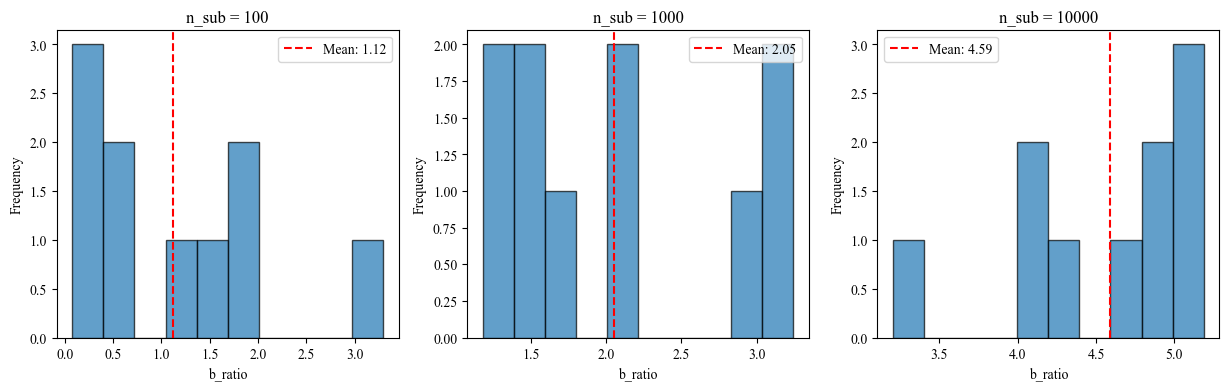

In [169]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, n_sub in enumerate([100, 1000, 10000]):
    results = all_results[n_sub]
    b_ratios = [r['b_ratio'] for r in results]
    
    axes[idx].hist(b_ratios, bins=10, edgecolor='black', alpha=0.7)
    axes[idx].axvline(np.mean(b_ratios), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(b_ratios):.2f}')
    axes[idx].set_xlabel('b_ratio')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'n_sub = {n_sub}')
    axes[idx].legend()

In [139]:
base_idx

sampled_idx = rng.choice(base_idx, size=len(base_idx), replace=True)
d = base_idx.loc[sampled_idx]

print("Number of rows in d:", len(d))
print("Number of unique indices:", d.index.nunique())

AttributeError: 'Index' object has no attribute 'loc'

In [119]:
def bootstrap_90_exact(alpha, sf_mask, q_mask, bins=18, N=10_000, seed=None):

    rng = np.random.default_rng(seed)

    bin_edges = np.linspace(0, 90, bins + 1)
    bin_idx = np.digitize(alpha, bin_edges) - 1

    valid = (bin_idx >= 0) & (bin_idx < bins)
    bin_idx = bin_idx[valid]
    sf_mask = sf_mask[valid]
    q_mask  = q_mask[valid]

    n = len(bin_idx)
    boot_fq = np.zeros((N, bins))

    for i in range(N):
        idx = rng.integers(0, n, size=n)

        b = bin_idx[idx]
        sf = sf_mask[idx]
        q  = q_mask[idx]

        sf_counts = np.bincount(b[sf], minlength=bins)
        q_counts  = np.bincount(b[q],  minlength=bins)

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = q_counts / (q_counts + sf_counts)

        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq

    return boot_fq.mean(axis=0), boot_fq.std(axis=0)

In [133]:
def bootstrap_90_exact(alpha, sf_mask, q_mask, bins=18, N=10_000, seed=None):
    rng = np.random.default_rng(seed)

    bin_edges = np.linspace(0, 90, bins + 1)
    n = len(alpha)
    boot_fq = np.zeros((N, bins))

    for i in range(N):
        # resample row indices with replacement
        sampled_idx = rng.integers(0, n, size=n)

        alpha_samp = alpha[sampled_idx]
        sf_samp    = sf_mask[sampled_idx]
        q_samp     = q_mask[sampled_idx]

        # use np.histogram (identical to original)
        g_N_sf, _ = np.histogram(alpha_samp[sf_samp], bins=bins, range=(0,90))
        g_N_q,  _ = np.histogram(alpha_samp[q_samp],  bins=bins, range=(0,90))

        with np.errstate(divide='ignore', invalid='ignore'):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0
        boot_fq[i] = fq

    return boot_fq.mean(axis=0), boot_fq.std(axis=0)

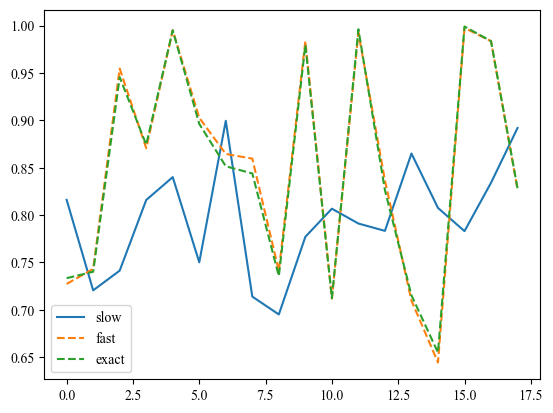

In [141]:
fq_slow_mean, fq_slow_std = bootstrap_90(
    sub_sfr, sub_sf, sub_q, N=2000
)

fq_fast_mean, fq_fast_std = bootstrap_90_fast(
    alpha, sf, q, N=2000
)

fq_exact_mean, fq_exact_std = bootstrap_90_exact(
    alpha, sf, q, N=2000
)


plt.plot(fq_slow_mean, label="slow")
plt.plot(fq_fast_mean, '--', label="fast")
plt.plot(fq_exact_mean, '--', label="exact")

plt.legend()


In [138]:
sampled_idx = rng.choice(base_idx, size=len(base_idx), replace=True)
d = data.loc[sampled_idx]

print("Number of rows in d:", len(d))
print("Number of unique indices:", d.index.nunique())

NameError: name 'data' is not defined

In [127]:
# boostrap TNG100 data 

#fq_mean_1e8, fq_std_1e8 = boostrap_90(tng100_sfr_info[index],index_sf,index_q,10000)
#fq_mean_1e7, fq_std_1e7 = boostrap_90(tng100_sfr_info[index],index_sf,index_q,10000)

rng = np.random.default_rng(42) # set random seed

subsample = rng.choice(tng100_sfr_info[index], size=2, replace=True)

#fq_mean_1e6, fq_std_1e6 = boostrap_90(tng100_sfr_info[index],index_sf,index_q,10000)

In [88]:
def calculate_log_likelihood(theta, bin_centers, f_q, sigma_i):

    a, b, f = theta

    # Compute total variance
    s_i = sigma_i**2 + (np.exp(f))**2

    # Model prediction
    f_model = a + b * np.cos(2 * np.radians(bin_centers))

    # Residuals and log-likelihood
    residuals = (f_q - f_model)**2 / s_i
    log_likelihood = -0.5 * np.sum(residuals + np.log(2 * np.pi * s_i))
    
    return log_likelihood

def log_prior(theta):
    a, b, f = theta
    if 0 < a < 1 and -1 < b < 1 and -10 < f < 2:
        return 0.0
    return -np.inf

def calculate_log_probability(theta, bin_centers, f_q, sigma_i):
    
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    log_likelihood = calculate_log_likelihood(theta, bin_centers, f_q, sigma_i)
    return log_prior_val + log_likelihood

In [8]:
# 1e6

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all

# 1e7

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e7, fq_std_1e7))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_1e7, b_1e7, f_1e7 = mean_params_tng100_all
a_1e7_std, b_1e7_std, f_1e7_std = std_params_tng100_all

# 1e8

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e8, fq_std_1e8))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_1e8, b_1e8, f_1e8 = mean_params_tng100_all
a_1e8_std, b_1e8_std, f_1e8_std = std_params_tng100_all

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1819.29it/s]


In [75]:
# re-fit SAGA and ELVES data with updated boostrapping 

# SAGA

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_saga, fq_std_saga))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_saga, b_saga, f_saga = mean_params_tng100_all
a_saga_std, b_saga_std, f_saga_std = std_params_tng100_all

# ELVES 

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_elves, fq_std_elves))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_elves, b_elves, f_elves = mean_params_tng100_all
a_elves_std, b_elves_std, f_elves_std = std_params_tng100_all

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1800.00it/s]


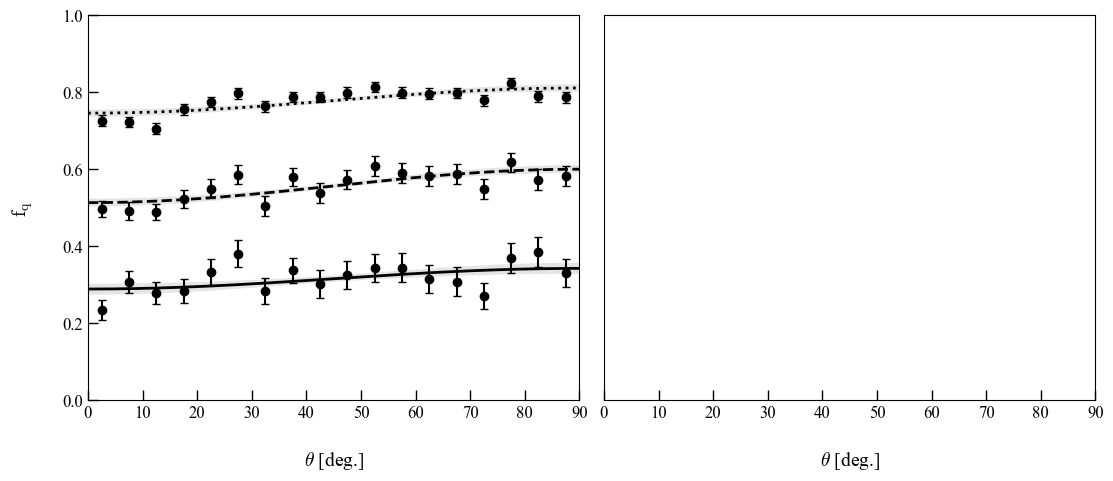

In [12]:
# New high-contrast colors
saga_line = '#1f77b4'
saga_fill = '#aec7e8'
elves_line = '#d62728'
elves_fill = '#ff9896'

fig, (ax_hist,ax_hist2) = plt.subplots(1, 2, figsize=(13, 5))

# SDSS, TNG, SMDPL (from Michael)

#sdss_fq = np.loadtxt('../../sdss/figure1/sdss_fq.txt')
#tng100_fq = np.loadtxt('../../sdss/figure1/tng100_fq.txt')
#smdpl_fq = np.loadtxt('../../sdss/figure1/smdpl_fq.txt')

ax_hist.errorbar(angle_array, fq_mean_1e8, yerr=fq_std_1e8,fmt='o', color='black', mfc='black', mec='black', mew=1,capsize=3)
ax_hist.errorbar(angle_array, fq_mean_1e7, yerr=fq_std_1e7,fmt='o', color='black', mfc='black', mec='black', mew=1,capsize=3)
ax_hist.errorbar(angle_array, fq_mean_1e6, yerr=fq_std_1e6,fmt='o', color='black', mfc='black', mec='black', mew=1,capsize=3)

x = np.linspace(0,np.pi/2,1000)
ax_hist.plot((x*u.rad).to('degree'),a_1e6 + b_1e6 * np.cos(2 * x),color='black', lw=2,ls=':')
ax_hist.plot((x*u.rad).to('degree'),a_1e7 + b_1e7 * np.cos(2 * x),color='black', lw=2,ls='--')
ax_hist.plot((x*u.rad).to('degree'),a_1e8 + b_1e8 * np.cos(2 * x),color='black', lw=2,ls='-')

n_mc = 10000
a_samp = np.random.normal(a_1e6, a_1e6_std, n_mc)
b_samp = np.random.normal(b_1e6, b_1e6_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist.fill_between(theta_deg,y_low,y_high,color='k',alpha=0.1,edgecolor=None)

n_mc = 10000
a_samp = np.random.normal(a_1e7, a_1e7_std, n_mc)
b_samp = np.random.normal(b_1e7, b_1e7_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist.fill_between(theta_deg,y_low,y_high,color='k',alpha=0.1,edgecolor=None)

n_mc = 10000
a_samp = np.random.normal(a_1e8, a_1e8_std, n_mc)
b_samp = np.random.normal(b_1e8, b_1e8_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist.fill_between(theta_deg,y_low,y_high,color='k',alpha=0.1,edgecolor=None)



ax_hist.set_ylabel(r'$\mathrm{f_q}$', fontsize=14, labelpad=20)
ax_hist.set_xlabel(r'$\theta$ [deg.]', fontsize=14, labelpad=20)
ax_hist2.set_xlabel(r'$\theta$ [deg.]', fontsize=14, labelpad=20)

ax_hist.set_xlim(0, 90)
ax_hist2.set_xlim(0, 90)

ax_hist.set_ylim(0, 1)
ax_hist2.set_ylim(0, 1)

ax_hist.tick_params(axis="both", which="major", direction="in", labelsize=12, length=7, width=1)
ax_hist.tick_params(axis="both", which="minor", direction="in", labelsize=12, length=2, width=1)

ax_hist2.tick_params(axis="both", which="major", direction="in", labelsize=12, length=7, width=1)
ax_hist2.tick_params(axis="both", which="minor", direction="in", labelsize=12, length=2, width=1)

ax_hist2.set_yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

## BIC/AIC Analysis:

### Interpretation: If the amplitude b = 0, then the sinsoidal function is merely a constant, or the quench fraction. We can therefore ask, how many std away from 0 is the parameter b mean? We find that there is significant overlap in the SAGA and ELVES b parameter. However, there is less overlap in the TNG100-1 subsamples.

In [77]:
# calulate how many std the mean is from 0 (for the parameter b, such that b = 0 is consistent with a st)

n_mc = 100000
b_samp = np.random.normal(b_saga, b_saga_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_elves, b_elves_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_1e8, b_1e8_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_1e7, b_1e7_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_1e6, b_1e6_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

1.1739024012223869
0.7838275085902834
2.3251248244912897
4.950704396316425
4.183792570013034


In [78]:
# calculate the BIC (and AIC) for the sinusoidal fit versus constant
# be careful of f value -- is this an extra parmameter?

def sinusoid(x, a, b, f):
    
    return a + b * np.cos(2 * x)

def BIC(x_data, y_data, y_err, a_fit, b_fit, f_fit):

    resid = y_data - sinusoid(x_data, a_fit, b_fit, f_fit)
    print(resid)                       
    n = len(y_data)
    k = 2
    logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
    bic_sin = k * np.log(n) - 2 * logL
    print("BIC Sinudoid Fit =", bic_sin) 
    aic_sin = 2*k - 2*logL
    print("AIC Sinudoid Fit =", aic_sin) 

    resid_const = y_data - np.mean(y_data)
    k_const = 1
    logL_const = -0.5 * np.sum((resid_const / y_err)**2 + np.log(2*np.pi*y_err**2))
    bic_const = k_const * np.log(n) - 2 * logL_const
    print("BIC Constant Fit =", bic_const)
    aic_const = 2*k - 2*logL_const
    print("AIC Constant Fit =", aic_const) 

    print('Delta BIC =',np.abs(bic_const-bic_sin))
    print('Delta AIC =',np.abs(aic_const-aic_sin))
    if bic_const < bic_sin:
        print("From BIC, Constant model preferred")
    else:
        print("From BIC, Sinusoid model preferred")

    if aic_const < aic_sin:
        print("From AIC, Constant model preferred")
    else:
        print("From AIC, Sinusoid model preferred")

print('ELVES:')
BIC(angle_array, fq_mean_elves, fq_std_elves, a_elves, b_elves, f_elves)
print(' ')
print('SAGA:')
BIC(angle_array, fq_mean_saga, fq_std_saga, a_saga, b_saga, f_saga)
print(' ')
print('TNG100-1, > 1e8:')
BIC(angle_array, fq_mean_1e8, fq_std_1e8, a_1e8, b_1e8, f_1e8)
print(' ')
print('TNG100-1, > 1e7:')
BIC(angle_array, fq_mean_1e7, fq_std_1e7, a_1e7, b_1e7, f_1e7)
print(' ')
print('TNG100-1, > 1e6:')
BIC(angle_array, fq_mean_1e6, fq_std_1e6, a_1e6, b_1e6, f_1e6)

ELVES:
[-0.07615539  0.14032332 -0.21464277  0.28564547 -0.35816325  0.07687207
  0.22155317  0.04964239 -0.00860634 -0.01920763 -0.02841873 -0.44175459
 -0.21394678  0.29889651 -0.16124593 -0.02687768  0.01470273  0.01711617]
BIC Sinudoid Fit = 7.06127743686744
AIC Sinudoid Fit = 5.2805339210751105
BIC Constant Fit = -0.5999073817314384
AIC Constant Fit = 0.509720860372397
Delta BIC = 7.661184818598878
Delta AIC = 4.7708130607027135
From BIC, Constant model preferred
From AIC, Constant model preferred
 
SAGA:
[-0.03521531  0.06403515 -0.18655766  0.01474206 -0.05347483 -0.02980004
  0.10470021  0.1825617  -0.17999945 -0.13321574 -0.10469446  0.02614079
  0.07133391 -0.24176225  0.2621704   0.17259966  0.11562485 -0.014618  ]
BIC Sinudoid Fit = nan
AIC Sinudoid Fit = nan
BIC Constant Fit = nan
AIC Constant Fit = nan
Delta BIC = nan
Delta AIC = nan
From BIC, Sinusoid model preferred
From AIC, Sinusoid model preferred
 
TNG100-1, > 1e8:
[-0.07280828 -0.02943918 -0.01034389 -0.05603418  0

/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:14: RuntimeWarning: divide by zero encountered in divide
  logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:14: RuntimeWarning: divide by zero encountered in log
  logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:14: RuntimeWarning: invalid value encountered in add
  logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:22: RuntimeWarning: divide by zero encountered in divide
  logL_const = -0.5 * np.sum((resid_const / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:22: RuntimeWarning: divide by zero encountered in log
  logL_const = -0.5 * np.sum((resid_co

### Interpretation: Instead of looking at the amplitude b, we can instead ask: How much better of a fit is the sinusoidal function compared to a constant (the mean quench fraction across all angle bins). This can be calculated using both the BIC (penalizes number of paramaeters more) and AIC. We find that all data are better fit with a constant. Supposedly the AIC for the SAGA data is slightly lower for the sinusoid compared to the constant model, but the $\Delta$BIC is 1.15. As a good rule of thumb, > 10 suggests that there is strong evidence.

## Old Code from Nick:

## Alignment Test

In [289]:

#SAGA
theta_deg = np.array(saga_90)  # your folded angles
theta_rad = np.deg2rad(theta_deg)

# Effect size
A_obs = np.mean(np.cos(2 * theta_rad))

# Bootstrap CI
B = 5000
rng = np.random.default_rng(0)
A_boot = []
n = len(theta_rad)

for _ in range(B):
    sample = rng.choice(theta_rad, size=n, replace=True)
    A_boot.append(np.mean(np.cos(2 * sample)))

lo, hi = np.percentile(A_boot, [2.5, 97.5])
print("SAGA")
print(f"<cos(2θ)> = {A_obs:.4f}")
print(f"95% CI: [{lo:.4f}, {hi:.4f}]")


SAGA
<cos(2θ)> = -0.0645
95% CI: [-0.1458, 0.0176]


In [290]:

#ELVES
theta_deg = np.array(elves_90)  # your folded angles
theta_rad = np.deg2rad(theta_deg)

# Effect size
A_obs = np.mean(np.cos(2 * theta_rad))

# Bootstrap CI
B = 5000
rng = np.random.default_rng(0)
A_boot = []
n = len(theta_rad)

for _ in range(B):
    sample = rng.choice(theta_rad, size=n, replace=True)
    A_boot.append(np.mean(np.cos(2 * sample)))

lo, hi = np.percentile(A_boot, [2.5, 97.5])
print("ELVES")
print(f"<cos(2θ)> = {A_obs:.4f}")
print(f"95% CI: [{lo:.4f}, {hi:.4f}]")

ELVES
<cos(2θ)> = 0.0119
95% CI: [-0.0946, 0.1170]


In [293]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import kstest

print("SAGA: Testing Whether Quench and Star forming follow different distribution")
# Inputs:
# theta_deg: folded angles in [0, 90], shape (N,)
# quenched:  1 for quenched, 0 for star-forming, shape (N,)
# host_id:   host identifier per satellite, shape (N,)
theta_deg = np.asarray(saga_90)
quenched  = np.asarray(saga_quenched).astype(int)
host_id   = np.asarray(saga_sats['HOSTID'][radius_limit])


# Split groups
th_q  = theta_deg[quenched == 1]
th_sf = theta_deg[quenched == 0]


print("saga:", kstest(theta_deg, 'uniform' , args=(0, 90)))


# --- (1) Two-sample KS ---
D, p_ks = ks_2samp(th_q, th_sf, alternative='two-sided')
# Extract scalar values to avoid formatting errors
D = D.item() if hasattr(D, 'item') else (float(D[0]) if hasattr(D, '__len__') else D)
p_ks = p_ks.item() if hasattr(p_ks, 'item') else (float(p_ks[0]) if hasattr(p_ks, '__len__') else p_ks)



# --- (2) ΔA effect size ---
c2 = np.cos(2 * np.deg2rad(theta_deg))
A_q  = c2[quenched == 1].mean()
A_sf = c2[quenched == 0].mean()
dA   = A_q - A_sf

print(f"KS: D={D:.4f}, p={p_ks:.3g}")
print(f"A_q={A_q:.4f}, A_sf={A_sf:.4f}, ΔA={dA:.4f}")

# --- (3) 95% CI for ΔA via cluster (host) bootstrap ---
rng = np.random.default_rng(0)
hosts = np.unique(host_id)
B = 5000
dA_boot = []

for _ in range(B):
    boot_hosts = rng.choice(hosts, size=len(hosts), replace=True)
    # keep all satellites belonging to sampled hosts
    mask = np.isin(host_id, boot_hosts)
    c2_b = c2[mask]
    q_b  = quenched[mask]
    if (q_b == 1).any() and (q_b == 0).any():
        dA_boot.append(c2_b[q_b==1].mean() - c2_b[q_b==0].mean())

lo, hi = np.percentile(dA_boot, [2.5, 97.5])
print(f"ΔA 95% CI: [{lo:.4f}, {hi:.4f}]")

# --- (4) Cluster-aware permutation p-values ---
# Permute labels WITHIN each host; preserves per-host clustering and class sizes.
def permute_labels_within_host(q, h, rng):
    q_perm = q.copy()
    for hh in np.unique(h):
        idx = np.where(h == hh)[0]
        q_perm[idx] = rng.permutation(q_perm[idx])
    return q_perm

Bperm = 5000
dA_perm = []
D_perm  = []

for _ in range(Bperm):
    q_p = permute_labels_within_host(quenched, host_id, rng)
    # ΔA under permuted labels
    A_q_p  = c2[q_p==1].mean() if (q_p==1).any() else np.nan
    A_sf_p = c2[q_p==0].mean() if (q_p==0).any() else np.nan
    dA_perm.append(A_q_p - A_sf_p)

    # KS under permuted labels
    th_q_p  = theta_deg[q_p == 1]
    th_sf_p = theta_deg[q_p == 0]
    if len(th_q_p) > 0 and len(th_sf_p) > 0:
        Dp, _ = ks_2samp(th_q_p, th_sf_p, alternative='two-sided')
        D_perm.append(Dp.item() if hasattr(Dp, 'item') else (float(Dp[0]) if hasattr(Dp, '__len__') else Dp))

dA_perm = np.array(dA_perm, dtype=float)
D_perm  = np.array(D_perm, dtype=float)

p_perm_dA = (np.sum(np.abs(dA_perm) >= abs(dA)) + 1) / (np.sum(~np.isnan(dA_perm)) + 1)
p_perm_KS = (np.sum(D_perm >= D) + 1) / (len(D_perm) + 1)

print(f"Permutation p (ΔA): {p_perm_dA:.4g}")
print(f"Permutation p (KS): {p_perm_KS:.4g}")


SAGA: Testing Whether Quench and Star forming follow different distribution
saga: KstestResult(statistic=0.07812443594645685, pvalue=0.059144035288726804, statistic_location=46.64387529151915, statistic_sign=-1)
KS: D=0.1516, p=0.131
A_q=-0.1248, A_sf=-0.0417, ΔA=-0.0832
ΔA 95% CI: [-0.2537, 0.0691]
Permutation p (ΔA): 0.4199
Permutation p (KS): 0.1616


In [294]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import kstest

print("ELVES: Testing Whether Quench and Star forming follow different distribution")
# Inputs:
# theta_deg: folded angles in [0, 90], shape (N,)
# quenched:  1 for quenched, 0 for star-forming, shape (N,)
# host_id:   host identifier per satellite, shape (N,)
theta_deg = np.asarray(elves_90)
quenched  = np.asarray(elves_quenched).astype(int)
# Use the kept_indices from the ELVES processing to get the correct host IDs
host_id   = np.asarray(sats['Host'].iloc[kept_indices])


# Split groups
th_q  = theta_deg[quenched == 1]
th_sf = theta_deg[quenched == 0]


print("ELVES:", kstest(theta_deg, 'uniform' , args=(0, 90)))


# --- (1) Two-sample KS ---
D, p_ks = ks_2samp(th_q, th_sf, alternative='two-sided')
# Extract scalar values to avoid formatting errors
D = D.item() if hasattr(D, 'item') else (float(D[0]) if hasattr(D, '__len__') else D)
p_ks = p_ks.item() if hasattr(p_ks, 'item') else (float(p_ks[0]) if hasattr(p_ks, '__len__') else p_ks)



# --- (2) ΔA effect size ---
c2 = np.cos(2 * np.deg2rad(theta_deg))
A_q  = c2[quenched == 1].mean()
A_sf = c2[quenched == 0].mean()
dA   = A_q - A_sf

print(f"KS: D={D:.4f}, p={p_ks:.3g}")
print(f"A_q={A_q:.4f}, A_sf={A_sf:.4f}, ΔA={dA:.4f}")

# --- (3) 95% CI for ΔA via cluster (host) bootstrap ---
rng = np.random.default_rng(0)
hosts = np.unique(host_id)
B = 5000
dA_boot = []

for _ in range(B):
    boot_hosts = rng.choice(hosts, size=len(hosts), replace=True)
    # keep all satellites belonging to sampled hosts
    mask = np.isin(host_id, boot_hosts)
    c2_b = c2[mask]
    q_b  = quenched[mask]
    if (q_b == 1).any() and (q_b == 0).any():
        dA_boot.append(c2_b[q_b==1].mean() - c2_b[q_b==0].mean())

lo, hi = np.percentile(dA_boot, [2.5, 97.5])
print(f"ΔA 95% CI: [{lo:.4f}, {hi:.4f}]")

# --- (4) Cluster-aware permutation p-values ---
# Permute labels WITHIN each host; preserves per-host clustering and class sizes.
def permute_labels_within_host(q, h, rng):
    q_perm = q.copy()
    for hh in np.unique(h):
        idx = np.where(h == hh)[0]
        q_perm[idx] = rng.permutation(q_perm[idx])
    return q_perm

Bperm = 5000
dA_perm = []
D_perm  = []

for _ in range(Bperm):
    q_p = permute_labels_within_host(quenched, host_id, rng)
    # ΔA under permuted labels
    A_q_p  = c2[q_p==1].mean() if (q_p==1).any() else np.nan
    A_sf_p = c2[q_p==0].mean() if (q_p==0).any() else np.nan
    dA_perm.append(A_q_p - A_sf_p)

    # KS under permuted labels
    th_q_p  = theta_deg[q_p == 1]
    th_sf_p = theta_deg[q_p == 0]
    if len(th_q_p) > 0 and len(th_sf_p) > 0:
        Dp, _ = ks_2samp(th_q_p, th_sf_p, alternative='two-sided')
        D_perm.append(Dp.item() if hasattr(Dp, 'item') else (float(Dp[0]) if hasattr(Dp, '__len__') else Dp))

dA_perm = np.array(dA_perm, dtype=float)
D_perm  = np.array(D_perm, dtype=float)

p_perm_dA = (np.sum(np.abs(dA_perm) >= abs(dA)) + 1) / (np.sum(~np.isnan(dA_perm)) + 1)
p_perm_KS = (np.sum(D_perm >= D) + 1) / (len(D_perm) + 1)

print(f"Permutation p (ΔA): {p_perm_dA:.4g}")
print(f"Permutation p (KS): {p_perm_KS:.4g}")


ELVES: Testing Whether Quench and Star forming follow different distribution
ELVES: KstestResult(statistic=array([0.05262737]), pvalue=array([0.69078043]), statistic_location=array([79.99070016]), statistic_sign=array([-1.]))
KS: D=0.1231, p=0.504
A_q=0.0385, A_sf=-0.0319, ΔA=0.0704
ΔA 95% CI: [-0.0447, 0.1611]
Permutation p (ΔA): 0.4967
Permutation p (KS): 0.4691
